# Pneumonia Detection From X-Ray Images Using CNN

## Objective
Identify which patients have pneumonia based on chest x-ray images

------
## Settings

### Libraries

In [48]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPool2D, Dense, LeakyReLU, Flatten, BatchNormalization, Dropout
from tensorflow.keras.backend import clear_session as clear_tf_session
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import math

### Data

In [2]:
path = Path("../data")
print([x.name for x in path.iterdir()])
print([x.name for x in Path(path / "train").iterdir()])

['train', 'test', 'val']
['pneumonia', 'normal']


In [3]:
sample_size = [
    {'Group': 'Train', 'Diagnostic': 'Normal', 'Number of images': len(list(Path(path / "train" / "normal").glob('*.jpeg')))},
    {'Group': 'Train', 'Diagnostic': 'Pneumonia', 'Number of images': len(list(Path(path / "train" / "pneumonia").glob('*.jpeg')))},
    {'Group': 'Validation', 'Diagnostic': 'Normal', 'Number of images': len(list(Path(path / "val" / "normal").glob('*.jpeg')))},
    {'Group': 'Validation', 'Diagnostic': 'Pneumonia', 'Number of images': len(list(Path(path / "val" / "pneumonia").glob('*.jpeg')))},
    {'Group': 'Test', 'Diagnostic': 'Normal', 'Number of images': len(list(Path(path / "test" / "normal").glob('*.jpeg')))},
    {'Group': 'Test', 'Diagnostic': 'Pneumonia', 'Number of images': len(list(Path(path / "test" / "pneumonia").glob('*.jpeg')))},
]
sample_size = pd.DataFrame(sample_size).pivot(index = 'Group', columns = 'Diagnostic', values = 'Number of images')
sample_size

Diagnostic,Normal,Pneumonia
Group,,
Test,234,390
Train,1341,3875
Validation,8,8


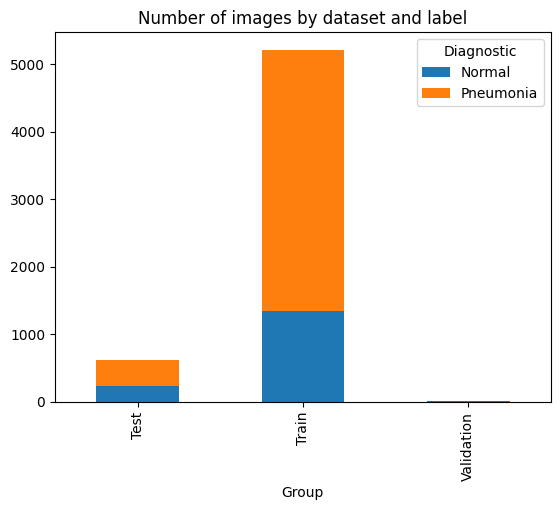

In [4]:
sample_size.plot.bar(stacked = True)
plt.title('Number of images by dataset and label')
plt.show()

In [5]:
path_generator = Path(path / "train" / "normal").iterdir()
X_train_normal = []
for i in range(100):
    image = cv.imread(next(path_generator).as_posix(), cv.IMREAD_GRAYSCALE)
    if image is not None:
        X_train_normal.append(image)

In [6]:
path_generator = Path(path / "train" / "pneumonia").iterdir()
X_train_pneumonia = []
for i in range(100):
    image = cv.imread(next(path_generator).as_posix(), cv.IMREAD_GRAYSCALE)
    if image is not None:
        X_train_pneumonia.append(image)

### Explotary Data Analysis

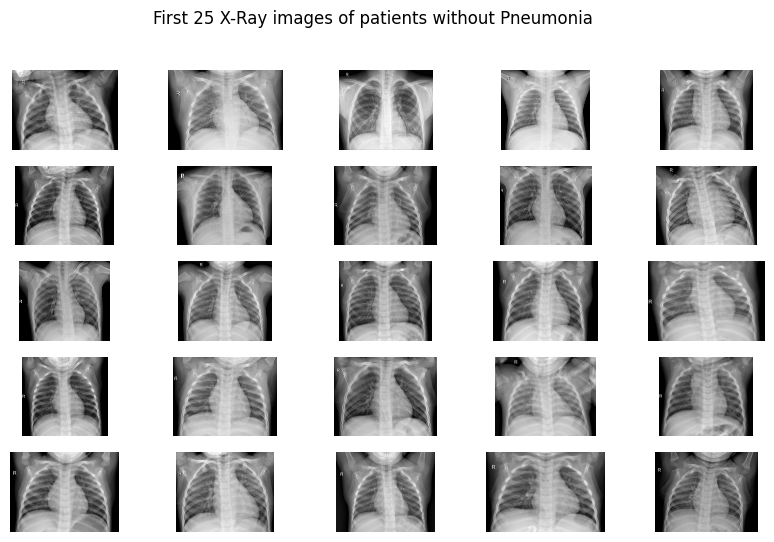

In [7]:
fig, axs = plt.subplots(5, 5)
i = 0
for row in axs:
    for ax in row:
        img = X_train_normal[i]
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        i += 1
fig.suptitle("First 25 X-Ray images of patients without Pneumonia")
fig.set_size_inches(10, 6)
fig.show()

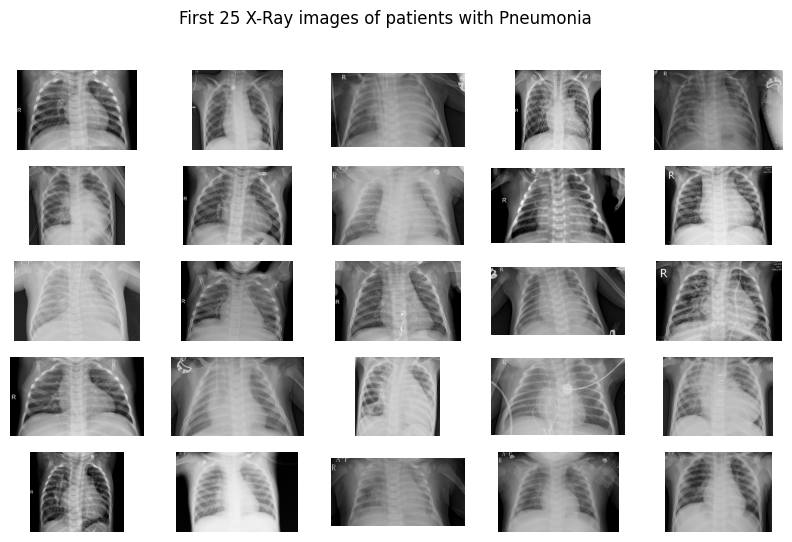

In [8]:
fig, axs = plt.subplots(5, 5)
i = 0
for row in axs:
    for ax in row:
        img = X_train_pneumonia[i]
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        i += 1
fig.suptitle("First 25 X-Ray images of patients with Pneumonia")
fig.set_size_inches(10, 6)
fig.show()

The images have different sizes. We need to deal with this before training the model.

In [9]:
dimensions = pd.DataFrame([img.shape for img in X_train_normal + X_train_pneumonia], columns = ["height", "width"])
dimensions.head()

,height,width
0,1082,1438
1,1496,2148
2,1672,1955
3,1936,2156
4,1433,1666


In [10]:
max_width = dimensions.width.max()
max_height = dimensions.height.max()
print(f"The maximum dimensions in this subset of training set are:")
print(f"Max height: {max_height}")
print(f"Max width: {max_width}")

The maximum dimensions in this subset of training set are:
Max height: 2540
Max width: 2428


### Preprocessing

The images need to have the same size for us to train and use a Convolutional Neural Network to clasify them. We will follow the recommendations of [this research paper](https://www.researchgate.net/publication/337260457_Enlarging_smaller_images_before_inputting_into_convolutional_neural_network_zero-padding_vs_interpolation), and add zero padding to make all images the same size as the largest image in the training data.

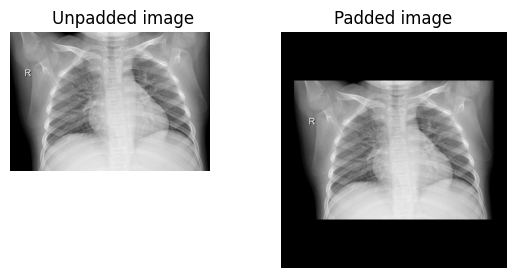

In [11]:
unpadded_img = X_train_normal[1]
horizontal_padding = (max_width - unpadded_img.shape[1]) / 2
vertical_padding = (max_height - unpadded_img.shape[0]) / 2
padded_img = cv.copyMakeBorder(
    unpadded_img,
    top = math.ceil(vertical_padding),
    bottom = math.floor(vertical_padding),
    left = math.ceil(horizontal_padding),
    right = math.floor(horizontal_padding),
    borderType = cv.BORDER_CONSTANT,
    value = 0 
)
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True)
axs[0].imshow(unpadded_img, cmap = "gray")
axs[0].set_title("Unpadded image")
axs[0].set_axis_off()
axs[1].imshow(padded_img, cmap = "gray")
axs[1].set_title("Padded image")
axs[1].set_axis_off()
plt.show()

In [12]:
del X_train_normal
del X_train_pneumonia
del dimensions

### Model Pipeline

Because there are too many images to be loaded into memory, we will need to build an input pipeline to read and preprocess batches of images, and train the Convolutional Neural Network with each subsequent batch.

#### Loading data

In [43]:
# Dataset params
image_size = (1000, 1000)
batch_size = 5
label_mode = 'binary'
color_mode = 'grayscale'
crop_to_aspect_ratio = False
seed = 888

In [ ]:
train_dataset = image_dataset_from_directory(
    path / 'train',
    label_mode = label_mode,
    color_mode = color_mode,
    batch_size = batch_size,
    crop_to_aspect_ratio = crop_to_aspect_ratio,
    seed = seed,
    image_size = image_size
)

In [28]:
class_names = train_dataset.class_names
class_names

['normal', 'pneumonia']

In [29]:
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
del image_batch
del labels_batch

(5, 1000, 1000, 1)
(5, 1)


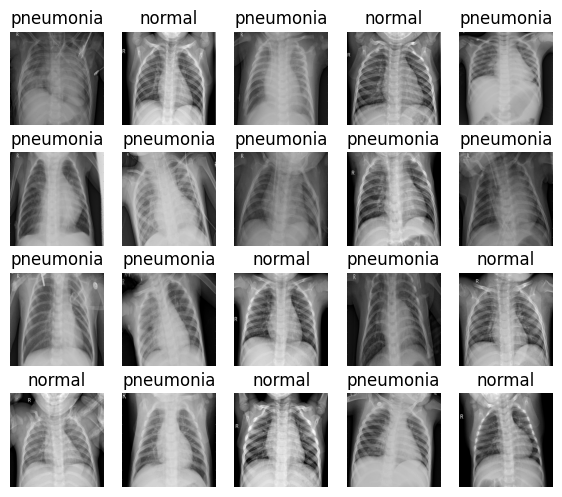

In [30]:
fig, axs = plt.subplots(4, 5)
fig.set_size_inches(7, 6)
for batch, row in zip(train_dataset.take(4), axs):
    images, labels = batch
    for ax, image, label in zip(row, images, labels):
        ax.imshow(image.numpy().astype("uint8"), cmap = 'gray')
        ax.set_title(class_names[int(label)])
        ax.axis('off')
plt.show()

In [44]:
test_dataset = image_dataset_from_directory(
    path / 'test',
    label_mode = label_mode,
    color_mode = color_mode,
    batch_size = batch_size,
    crop_to_aspect_ratio = crop_to_aspect_ratio,
    seed = seed,
    image_size = image_size
)

Found 624 files belonging to 2 classes.


#### Training model

In [70]:
clear_tf_session()
model = Sequential([
    Rescaling(1./255, input_shape = (*image_size, 1)),
    Conv2D(filters = 16, kernel_size = 3, padding = 'same'),
    LeakyReLU(alpha = 0.2),
    MaxPool2D(pool_size = 3),
    Conv2D(filters = 32, kernel_size = 3, padding = 'same'),
    LeakyReLU(alpha = 0.2),
    MaxPool2D(pool_size = 3),
    #Conv2D(filters = 32, kernel_size = 3, padding = 'same'),
    #LeakyReLU(alpha = 0.2),
    #MaxPool2D(pool_size = 3),
    BatchNormalization(),
    Flatten(),
    Dense(16),
    LeakyReLU(alpha = 0.1),
    Dropout(0.5),
    Dense(32),
    LeakyReLU(alpha = 0.1),
    Dropout(0.3),
    Dense(2)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 1000, 1000, 1)     0         
                                                                 
 conv2d (Conv2D)             (None, 1000, 1000, 16)    160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000, 1000, 16)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 333, 333, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 333, 333, 32)      4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 333, 333, 32)      0         
                                                        

In [71]:
optimizer = Adam(learning_rate=0.001)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=['accuracy']
)

In [72]:
model_history = model.fit(train_dataset, epochs = 5, validation_data = test_dataset)

Epoch 1/5
1044/1044 [==============================] - 48s 44ms/step - loss: 1.1940 - accuracy: 0.8340 - val_loss: 1.0754 - val_accuracy: 0.7228
Epoch 2/5
1044/1044 [==============================] - 42s 40ms/step - loss: 0.2319 - accuracy: 0.9203 - val_loss: 1.4393 - val_accuracy: 0.7869
Epoch 3/5
1044/1044 [==============================] - 42s 40ms/step - loss: 0.2057 - accuracy: 0.9358 - val_loss: 3.0351 - val_accuracy: 0.7772
Epoch 4/5
1044/1044 [==============================] - 42s 40ms/step - loss: 0.1274 - accuracy: 0.9553 - val_loss: 1.7766 - val_accuracy: 0.8205
Epoch 5/5
1044/1044 [==============================] - 42s 40ms/step - loss: 0.1462 - accuracy: 0.9567 - val_loss: 2.1277 - val_accuracy: 0.8910
